<table style='border: none' align='left'>
   <tr style='border: none'>
      <th style='border: none'><font size='5' face='verdana' color='black'><b>Use R to forecast time series data</b></th>
      <th style='border: none'><img src='https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true' alt='Watson Machine Learning icon' height='40' width='40'></th>
   </tr>
</table>

This notebook takes you through the steps of building a time series model. You will set up your environment and use data from the <a href="https://pkg.yangzhuoranyang.com/tsdl/" target="_blank" rel="noopener noreferrer">Time Series Data Libray package</a>, dealing with: **Monthly number of employed persons in Australia**. Next, you will learn how to visualize and modify the time series data with the necessary libraries. The notebook will teach you how to analyze the time series data and come to conclusions about the stationarity and optimal parameters of the time series data and its model. After you've selected the model with tuned parameters, you will be able to efficiently forecasts the time series data.

This notebook uses R, the tsdl library, and the forecast library. The "tsdl: Time Series Data Library" package is available under a GPL-3 license. For more information, see <a href="https://pkg.yangzhuoranyang.com/tsdl/" target="_blank" rel="noopener noreferrer">https://pkg.yangzhuoranyang.com/tsdl/</a>

## Learning Goals
- Load data saved as a project asset as a dataframe
    - Create a time series object
- Explore data
    - Check the stationarity of the time series
        - Seasonal decomposition
        - Dicky-Fuller test
- Prepare data - stationarizing the series
- Optimize the ARIMA parameters and create the model
    - ACF and PACF plots to identify parameters
    - Use grid search for ARIMA
- Train the model
- Test the model using forecasting

## Contents

1. [Load data](#loaddata)
2. [Explore data](#explore)
3. [Prepare data](#prepare)
4. [Model selection](#modelselection)
5. [Summary and next steps](#summary)

<a id='loaddata'></a>
## 1. Load data

In this section, you will load the time series data as a dataframe and a time series object.

This dataset contains records of the number of employed persons in Australia per month. You'll use the data set starting from January 1985 and onwards.

First, install the <a href="https://pkg.yangzhuoranyang.com/tsdl/" target="_blank" rel="noopener noreferrer">Time Series Data Libray package (tsdl)</a>. This is a data libray that was created by Rob Hyndman a Statistics Professor at Monash University, Australia.

In [1]:
# Install Time Series Data Library
library(devtools)
devtools::install_github("FinYang/tsdl")
library(tsdl)
tsdl

from URL https://api.github.com/repos/FinYang/tsdl/zipball/master
Installing tsdl
'/opt/conda/envs/R/lib/R/bin/R' --no-site-file --no-environ --no-save  \
  --no-restore --quiet CMD INSTALL  \
  '/home/dsxuser/.tmp/RtmpSrA8zy/devtools2bc7676557f/FinYang-tsdl-d1bfa3b'  \
  --library='/opt/conda/envs/R/lib/R/library' --install-tests 



Time Series Data Library: 648 time series  

                       Frequency
Subject                 0.1 0.25   1   4   5   6  12  13  52 365 Total
  Agriculture             0    0  37   0   0   0   3   0   0   0    40
  Chemistry               0    0   8   0   0   0   0   0   0   0     8
  Computing               0    0   6   0   0   0   0   0   0   0     6
  Crime                   0    0   1   0   0   0   2   1   0   0     4
  Demography              1    0   9   2   0   0   3   0   0   2    17
  Ecology                 0    0  23   0   0   0   0   0   0   0    23
  Finance                 0    0  23   5   0   0  20   0   2   1    51
  Health                  0    0   8   0   0   0   6   0   1   0    15
  Hydrology               0    0  42   0   0   0  78   1   0   6   127
  Industry                0    0   9   0   0   0   2   0   1   0    12
  Labour market           0    0   3   4   0   0  17   0   0   0    24
  Macroeconomic           0    0  18  33   0   0   5   0   0   0    56

Now, subset the library to obtain the data set you want - in this case, the Monthly number of employed persons in Australia. The data is loaded as a time series object.

You'll also load the forecast package here. The <a href="https://www.rdocumentation.org/packages/forecast" target="_blank" rel="noopener noreferrer">forecast</a> package in R is useful for time series because it contains tools to analyze and interact with the time series data and models.

In [2]:
# Get the time series data of employment statistics
library(forecast)
labour <- subset(tsdl,"Labour market", source = "Australian Bureau of Statistics")
employed_data_full <- subset(labour[[2]], start=84, end=143)
employed_data_full

Time Series:
Start = 1984.99966666667 
End = 1989.91633333333 
Frequency = 12 
 [1] 6452.4 6595.7 6657.4 6588.8 6658.0 6659.4 6703.4 6675.6 6814.7 6771.1
[11] 6882.0 6910.8 6753.6 6861.9 6961.9 6997.9 6979.0 7007.7 6991.5 6918.6
[21] 7040.6 7030.4 7034.2 7116.8 6902.5 7022.3 7133.4 7109.6 7103.6 7128.9
[31] 7175.6 7092.3 7186.5 7177.4 7182.2 7330.7 7169.4 7247.4 7397.4 7383.4
[41] 7354.9 7378.3 7383.1 7353.4 7503.2 7477.3 7508.7 7622.9 7424.9 7569.7
[51] 7638.3 7683.2 7729.3 7720.5 7751.8 7727.6 7854.4 7817.8 7870.7 7941.6

Before the data set is loaded as a dataframe, the Month column should be converted into an appropriate Date format.

To see the dataframe, run the following code.

In [3]:
# Data frame of time series data
Month <- seq(as.Date("1985-01-01"), as.Date("1989-12-01"), by="months")
Employed <- employed_data_full
df_data <- data.frame(Month, Employed)
df_data

Month,Employed
1985-01-01,6452.4
1985-02-01,6595.7
1985-03-01,6657.4
1985-04-01,6588.8
1985-05-01,6658.0
1985-06-01,6659.4
1985-07-01,6703.4
1985-08-01,6675.6
1985-09-01,6814.7
1985-10-01,6771.1


In [4]:
# Display internal structure of the dataframe
str(df_data)

'data.frame':	60 obs. of  2 variables:
 $ Month   : Date, format: "1985-01-01" "1985-02-01" ...
 $ Employed: Time-Series  from 1985 to 1990: 6452 6596 6657 6589 6658 ...


You can see that the Month column is a Date type.

In [5]:
# Show summary of the time series data
summary(employed_data_full)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   6452    6917    7131    7185    7438    7942 

Import the necessary data visualization libraries and plot the time series object to observe the pattern of the number of employed persons in Australia (in thousands) changing with time.

<a href="https://ggplot2.tidyverse.org/" target="_blank" rel="noopener noreferrer">ggplot2</a> is a commonly used visualization package in R, which uses layers to add specific visual aspects to the graphs.<br>

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


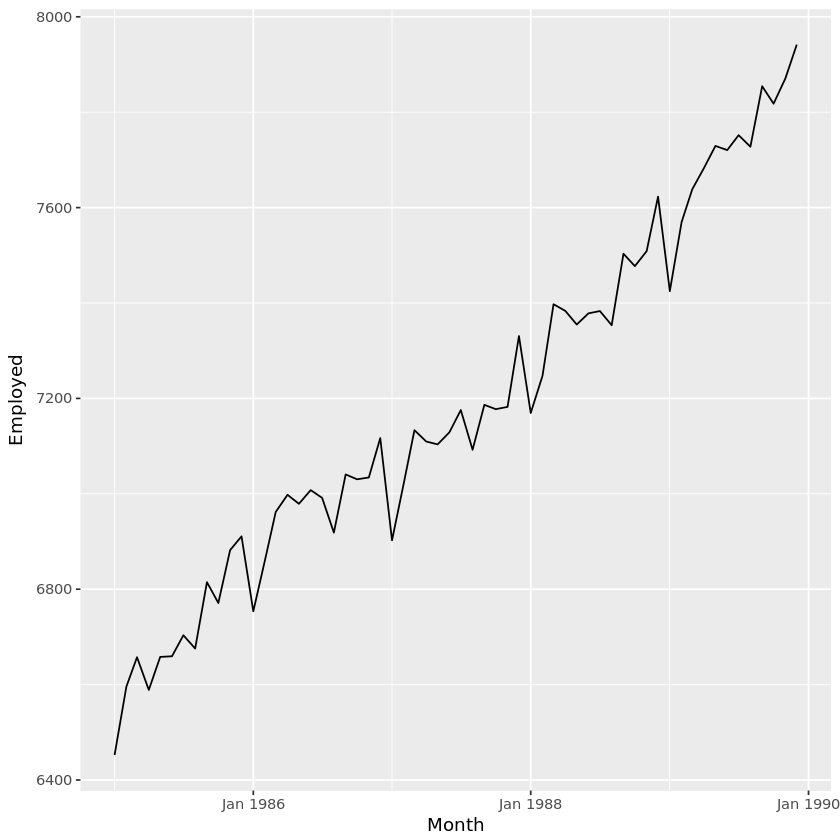

In [6]:
# Plot the time series data
library(ggplot2)
ggplot(data = df_data) + geom_line(aes(Month, Employed), group = 1) + scale_x_date(date_labels = "%b %Y") + xlab("Month") + ylab("Employed")

You can compare the seasonality of the time series data between each year.

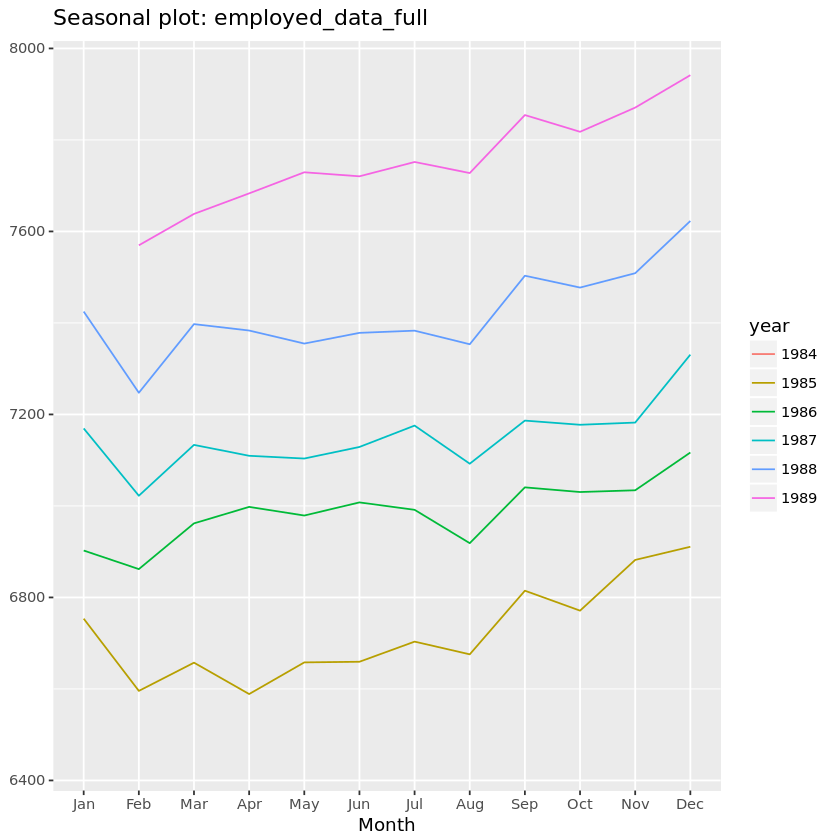

In [7]:
# Plot a graph showing the seasonality
ggseasonplot(employed_data_full)

<a id='explore'></a>
## 2. Explore data

In this section, you will explore the data to learn more about the stationarity of the series and determine the steps to take for data preparation.

### Check stationarity of time series<a id='stationary'></a>

You need to check the stationarity of the time series, since many models assume that the series is stationary. A time series is stationary when the mean, variance, and covariance of the data are constant and not dependent on time.

**Seasonal Decomposition**

Decompose the time series to observe the trend and seasonality in the data.

First, subset the training data.

In [8]:
employed_data <- subset(employed_data_full, start=1, end=48)
df_data_1 <- df_data[c(0:48),]
df_data_1

Month,Employed
1985-01-01,6452.4
1985-02-01,6595.7
1985-03-01,6657.4
1985-04-01,6588.8
1985-05-01,6658.0
1985-06-01,6659.4
1985-07-01,6703.4
1985-08-01,6675.6
1985-09-01,6814.7
1985-10-01,6771.1


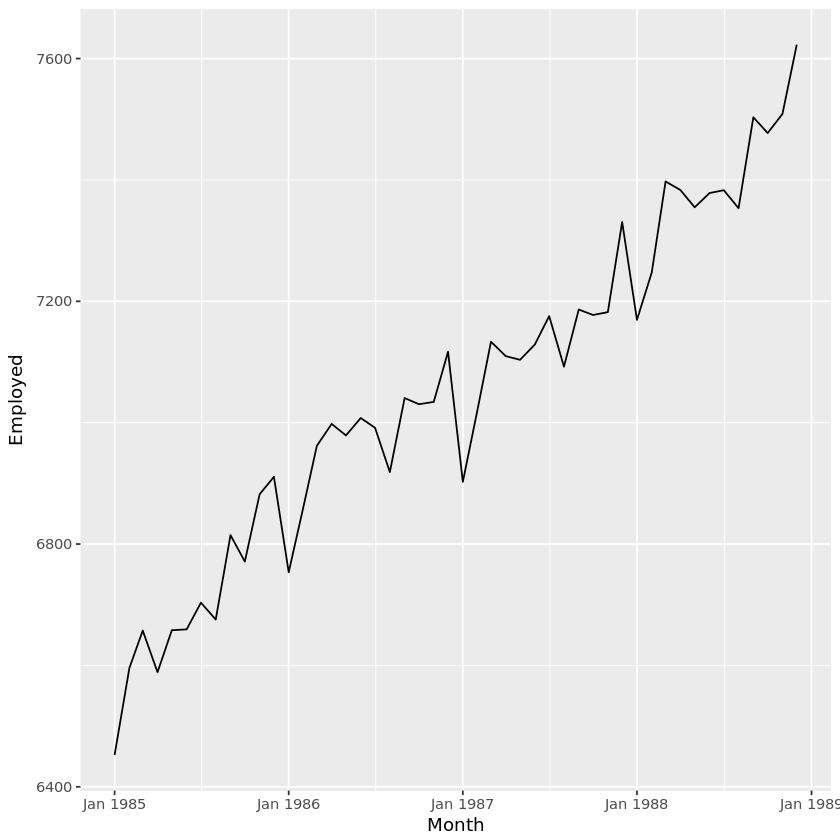

In [9]:
ggplot(data = df_data_1) + geom_line(aes(Month, Employed), group = 1) + scale_x_date(date_labels = "%b %Y") + xlab("Month") + ylab("Employed")

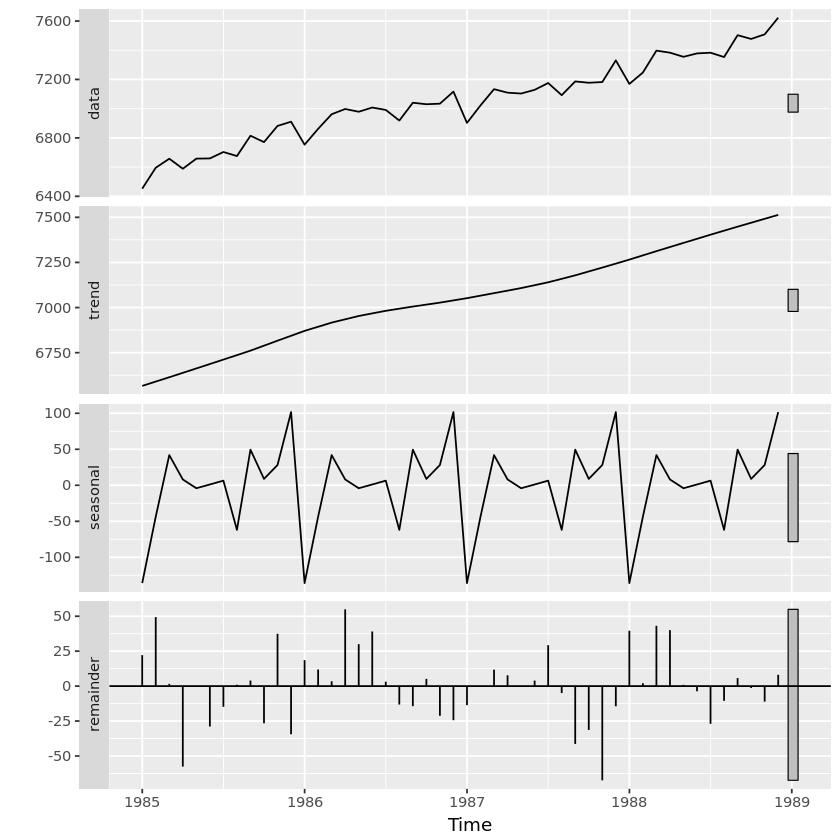

In [10]:
# Decomposition of the time series data
employed_data %>% stl(s.window="period") %>% autoplot

As you can see, the trend changes over time, so you can infer that the series is not stationary. You can also use an additional method, called the Dicky-Fuller test to confirm this observation.

**Augmented Dicky-Fuller Test**<br>

Use the Dicky-Fuller test to check the stationarity of the time series data. This analysis uses materials sourced from the "aTSA" R package, which is available under a GPL license. For more information about the "aTSA" package, see the <a href="https://cran.rstudio.com/web/packages/aTSA/index.html" target="_blank" rel="noopener noreferrer">documentation</a>.

In [11]:
# Install the Alternative Time Series Analysis package to test the time series data
install.packages("aTSA")
library(aTSA)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘aTSA’

The following object is masked from ‘package:forecast’:

    forecast

The following object is masked from ‘package:graphics’:

    identify



In [12]:
# Test the stationarity using the Augmented Dicky-Fuller Test
stationary.test(employed_data)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag  ADF p.value
[1,]   0 1.98   0.986
[2,]   1 2.68   0.990
[3,]   2 4.09   0.990
[4,]   3 3.55   0.990
Type 2: with drift no trend 
     lag     ADF p.value
[1,]   0 -1.1627   0.635
[2,]   1 -0.5051   0.865
[3,]   2 -0.0574   0.947
[4,]   3 -0.0745   0.945
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -5.83  0.0100
[2,]   1 -4.13  0.0124
[3,]   2 -2.34  0.4288
[4,]   3 -2.42  0.3970
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


The null hypothesis  $H_{o}$ assumes that the time series is dependent on time (that it is non-stationary). Since the p-value `0.397` is not significantly less than `|-2.42|`,  we cannot reject the null hypothesis that states the series is **non-stationary**.

<a id='prepare'></a>
## 3. Prepare data

3.1 [ACF & PACF plots](#acf)
<br>
3.2 [Stationarize the time series data](#station)

### 3.1 ACF & PACF plots<a id='acf'></a>

A common tool used to forecast time series data is the `ARIMA` (**A**uto **R**egressive **I**ntegrated **M**oving **A**verage) model. The model has 3 parameters 
- `p` - the parameter associated with the Auto-Regressive part of the ARIMA model. You can use the **PACF (partial autocorrelation function)** plot to find the optimal value.
- `d` - the parameter associated with the Integration part of the ARIMA model. This is the **order of difference**, or the number of times the time series is differenced in order to stationarize the series.
- `q` - the parameter associated with the Moving Average part of the ARIMA model. You can use the **ACF (autocorrelation function)** plot to find the optimal value.

Here are the ACF and PACF plots of the original time series data.

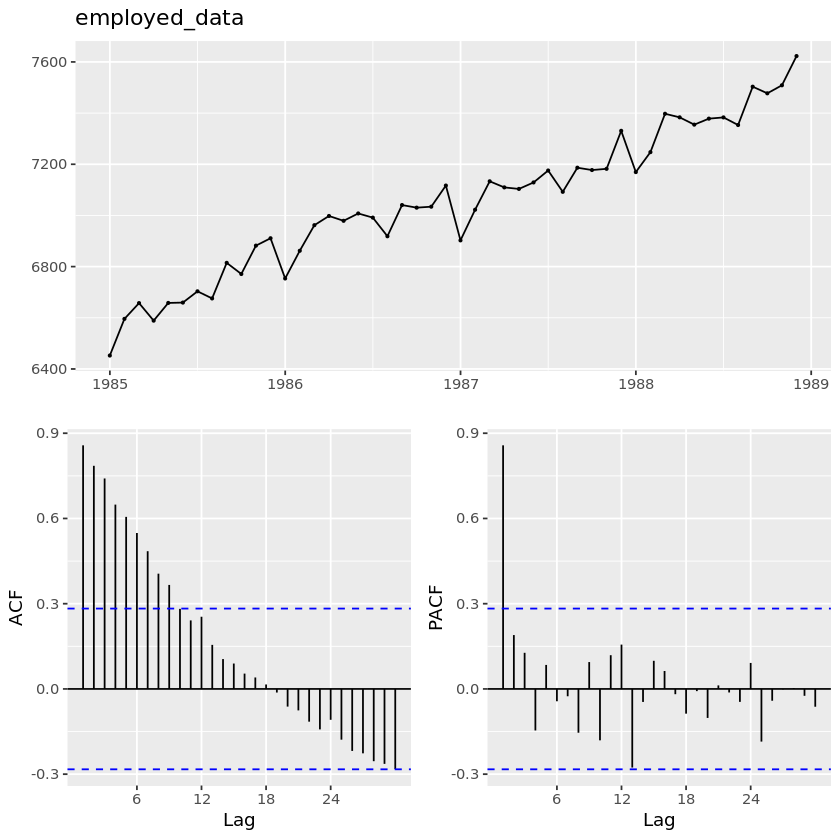

In [13]:
# Autocorrelation function and Partial autocorrelation function
ggtsdisplay(employed_data, lag.max=30)

But since the series is not stationary, you will first use differencing before finding the parameters for the model.

### 3.2 Stationarize the time series data <a id='station'></a>

 **Differencing** is used to remove the non-stationarity caused by the trend. The number of differences needed to remove stationarity determines the parameter d, for the Integration component of the ARIMA model. Run the following code to find the order of differencing that stationarizes the series.

In [14]:
# Find the order of differencing required to stationarize the series.
ndiffs(employed_data)

[1] 1

Now, you can run the code below to plot the ACF and PACF plots of the modified stationary data, which has been differenced one time.

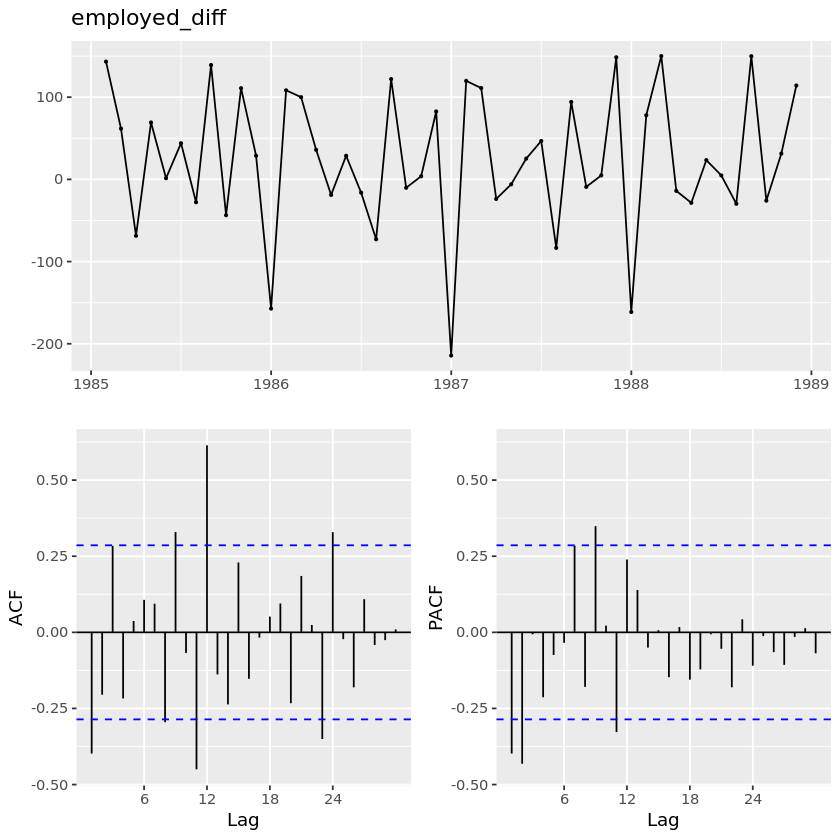

In [15]:
# Autocorrelation function and Partial autocorrelation function for the differenced data
employed_diff = diff(employed_data)
ggtsdisplay(employed_diff, lag.max=30)

The ACF plot shows that the first lag is significant. So, you can make a guess that the value for `q` is 1.

In the PACF plot, the second lag is significant, so you can set `p` to 2.

 You can observe the trend of the modified data using the seasonal decomposition method once again.

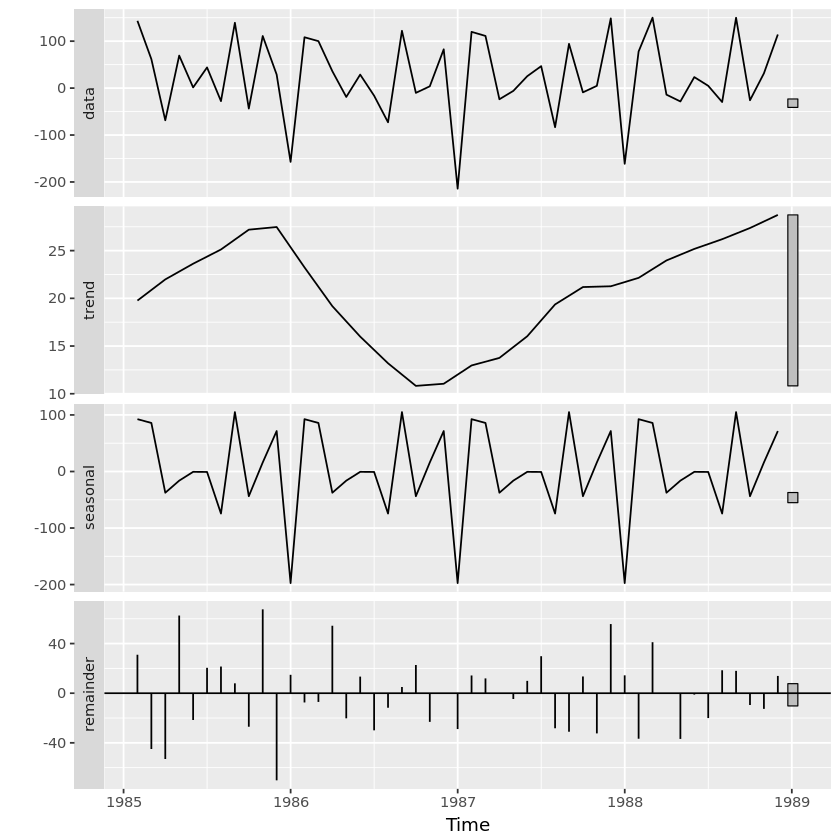

In [16]:
# Seasonal decomposition of the differenced data
employed_diff %>% stl(s.window="period") %>% autoplot

From the plot, you can see that there is no observable trend in the differenced time series data. Once again, you can use the Augmented Dicky-Fuller test to confirm that the stationarity of the data as well.

In [17]:
employed_data

Time Series:
Start = 1984.99966666667 
End = 1988.91633333333 
Frequency = 12 
 [1] 6452.4 6595.7 6657.4 6588.8 6658.0 6659.4 6703.4 6675.6 6814.7 6771.1
[11] 6882.0 6910.8 6753.6 6861.9 6961.9 6997.9 6979.0 7007.7 6991.5 6918.6
[21] 7040.6 7030.4 7034.2 7116.8 6902.5 7022.3 7133.4 7109.6 7103.6 7128.9
[31] 7175.6 7092.3 7186.5 7177.4 7182.2 7330.7 7169.4 7247.4 7397.4 7383.4
[41] 7354.9 7378.3 7383.1 7353.4 7503.2 7477.3 7508.7 7622.9

In [18]:
# Test the stationarity using the Augmented Dicky-Fuller Test
stationary.test(employed_diff)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag   ADF p.value
[1,]   0 -9.37    0.01
[2,]   1 -7.32    0.01
[3,]   2 -3.65    0.01
[4,]   3 -2.98    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -10.36    0.01
[2,]   1  -9.49    0.01
[3,]   2  -5.45    0.01
[4,]   3  -5.43    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -10.22    0.01
[2,]   1  -9.36    0.01
[3,]   2  -5.38    0.01
[4,]   3  -5.34    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


Again, the null hypothesis  $H_{o}$ assumes that the time series is dependent on time (that it is non-stationary). Since the p-value is <=`0.01` it is significantly less than `|-5.34|`,  we reject the null hypothesis and the series is **stationary**.

## 4. Model Selection <a id='modelselection'></a>

4.1 [Build the Model](#buildmodel)
<br>
4.2 [Forecast](#forecast)

### 4.1 Build the Model <a id='buildmodel'></a>

To check the optimal values for the ARIMA parameters, you can use the `auto arima` function.

In [19]:
# Perform grid search for ARIMA model (2, 1, 1)
modfit <- auto.arima(y = employed_data, d = 1, D=1, max.p = 3, start.p = 0,
  start.q = 0, seasonal = TRUE, ic = "aic", trace = TRUE, stepwise=FALSE)
summary(modfit)


 ARIMA(0,1,0)(0,1,0)[12]                    : 370.5039
 ARIMA(0,1,0)(0,1,1)[12]                    : 368.3318
 ARIMA(0,1,0)(1,1,0)[12]                    : 368.5368
 ARIMA(0,1,0)(1,1,1)[12]                    : 370.2102
 ARIMA(0,1,1)(0,1,0)[12]                    : 368.9989
 ARIMA(0,1,1)(0,1,1)[12]                    : 365.3101
 ARIMA(0,1,1)(1,1,0)[12]                    : 366
 ARIMA(0,1,1)(1,1,1)[12]                    : 367.2026
 ARIMA(0,1,2)(0,1,0)[12]                    : 370.8016
 ARIMA(0,1,2)(0,1,1)[12]                    : 367.0978
 ARIMA(0,1,2)(1,1,0)[12]                    : 367.431
 ARIMA(0,1,2)(1,1,1)[12]                    : 368.9098
 ARIMA(0,1,3)(0,1,0)[12]                    : 372.151
 ARIMA(0,1,3)(0,1,1)[12]                    : 369.0976
 ARIMA(0,1,3)(1,1,0)[12]                    : 369.4233
 ARIMA(0,1,3)(1,1,1)[12]                    : 370.9096
 ARIMA(0,1,4)(0,1,0)[12]                    : 373.8853
 ARIMA(0,1,4)(0,1,1)[12]                    : 370.2243
 ARIMA(0,1,4)(1,

The parameter set with the lowest `AIC` value (criteria that measures the model) is a good choice to fit the model. The model of `order = c(2, 1, 1)` found from the ACF and PACF plots has a minimum `AIC` value of `368.17` (with `seasonal = c(0, 1, 1)`). As you can see, however, the lowest `AIC` value is slightly better at about `365.31`, so the optimal parameters are `order = c(0, 1, 1)` and `seasonal = c(0, 1, 1)`.

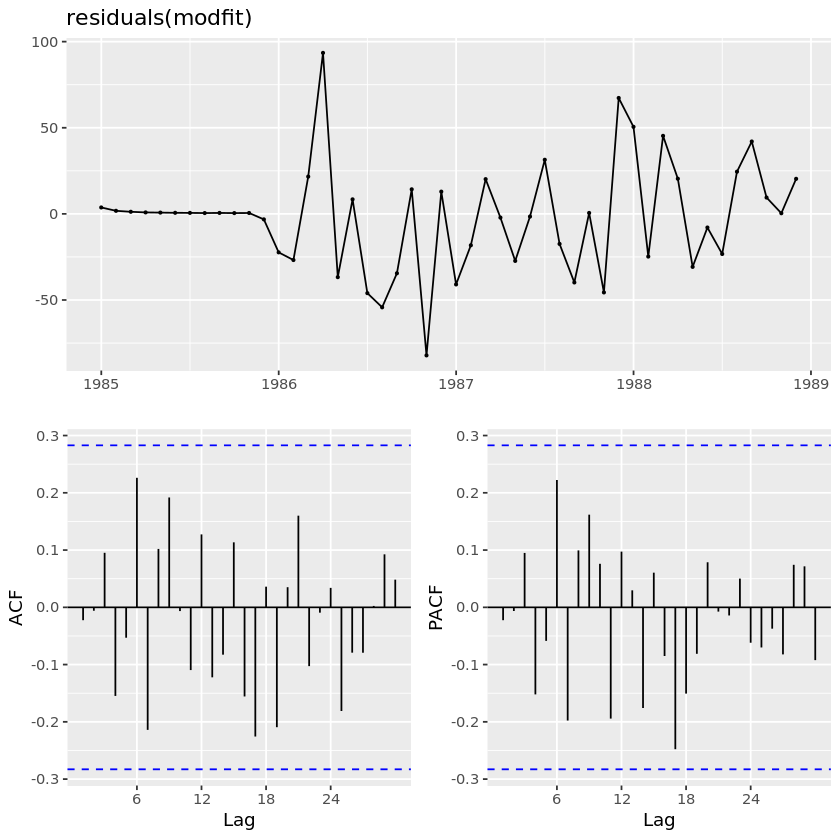

In [20]:
# Plot the residuals
ggtsdisplay(residuals(modfit), lag.max=30)

### 4.2 Forecast <a id='forecast'></a>

Now that you've built the model, you can use it to predict the number of employed people in the year 1990 and compare it with the observed numbers. You can run the code below to predict the observed values.

In [21]:
# Forecast the values for the next year (test data)
pred <- forecast::forecast(modfit, 12)
pred

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
1989.000       7436.924 7386.505 7487.342 7359.815 7514.032
1989.083       7544.446 7485.317 7603.575 7454.016 7634.876
1989.166       7657.206 7590.494 7723.918 7555.179 7759.233
1989.250       7640.952 7567.436 7714.469 7528.519 7753.386
1989.333       7638.674 7558.932 7718.417 7516.719 7760.630
1989.416       7659.557 7574.041 7745.074 7528.771 7790.343
1989.500       7678.187 7587.263 7769.112 7539.130 7817.244
1989.583       7625.796 7529.768 7721.825 7478.933 7772.659
1989.666       7753.268 7652.393 7854.142 7598.993 7907.542
1989.750       7731.728 7626.229 7837.226 7570.382 7893.074
1989.833       7765.320 7655.392 7875.247 7597.200 7933.439
1989.916       7865.744 7751.559 7979.929 7691.112 8040.376

Run this cell to plot the observed values with the predicted values and confidence intervals of both 80% and 95%.

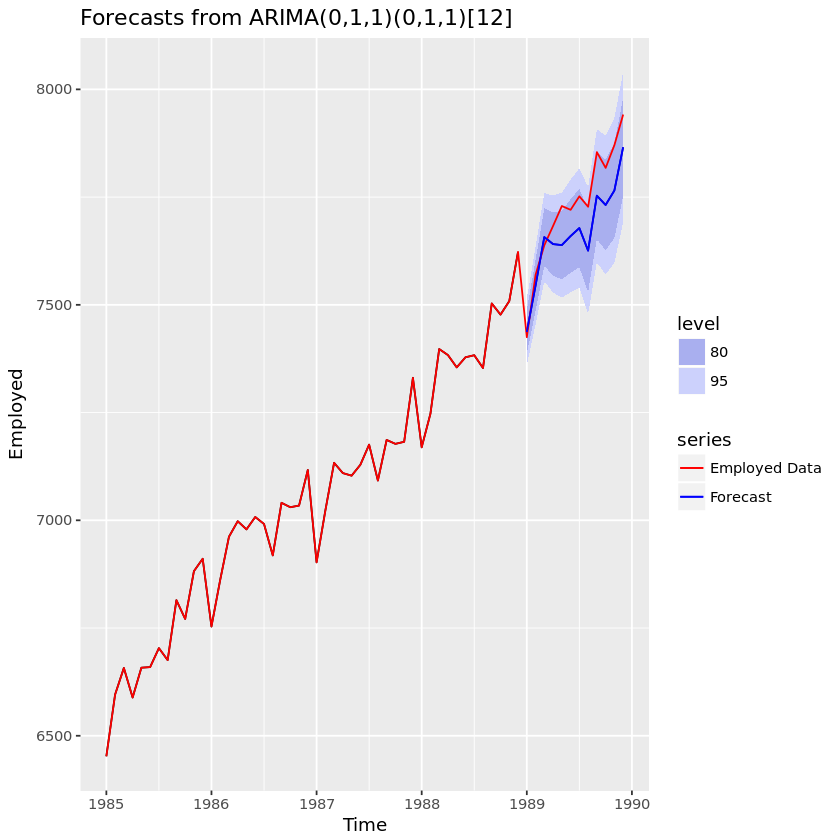

In [22]:
# Plot the forecasted values and the confidence intervals with the original data
true_val = ts(df_data$Employed[c(1:60)], start=c(1985, 1), end=c(1989, 12), frequency=12)
autoplot(pred) + xlab("Time") + ylab("Employed") +
    autolayer(true_val,series='Employed Data') +
    autolayer(pred$mean,series='Forecast') +
    scale_colour_manual(values=c("red", "blue"))

In the plot above, you can observe how the predicted values (in blue) measure up to the observed values (in red) during the year 1989. As you can see, the time series model built in this notebook does a good job of predicting the number of employed Australians close to the observed numbers.

## 5. Summary and next steps <a id='summary'></a>

You successfully completed this notebook and learned how to create a Time Series model. You can now analyze a time series data to check its stationarity, stationarize the series if necessary, and find the optimal parameters for the ARIMA model. You've learned how to use this model to forecast data with a confidence interval.

Check out our <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts.

### Data citations

Australian Bureau of Statistics (2012). <a href="https://www.abs.gov.au/" target="_blank" rel="noopener noreferrer">https://www.abs.gov.au/</a>

Rob Hyndman and Yangzhuoran Yang (2018). tsdl: Time Series Data Library. v0.1.0. <a href="https://pkg.yangzhuoranyang.com/tsdl/" target="_blank" rel="noopener noreferrer">https://pkg.yangzhuoranyang.com/tsdl/</a>

### Author

Ananya Kaushik is a Data Scientist at IBM.

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License. The "tsdl: Time Series Data Library" package is separately licensed under the terms of the GPL-3 license. For more information, see <a href="https://pkg.yangzhuoranyang.com/tsdl/" target="_blank" rel="noopener noreferrer">https://pkg.yangzhuoranyang.com/tsdl/</a>

<div style='background:#F5F7FA; height:110px; padding: 2em; font-size:14px;'>
<span style='font-size:18px;color:#152935;'>Love this notebook? </span>
<span style='font-size:15px;color:#152935;float:right;margin-right:40px;'>Don't have an account yet?</span><br>
<span style='color:#5A6872;'>Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style='border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;'><a href='https://ibm.co/wsnotebooks' target='_blank' style='color: #3d70b2;text-decoration: none;'>Sign Up</a></span><br>
</div>